In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import string
import re
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, get_file
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
tqdm().pandas()

<ipython-input-4-d1e3473017f5>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [ ]:
import os
from collections import defaultdict

captions_file = "/content/drive/MyDrive/Colab Notebooks/caption dataset/Flickr8k_text/Flickr8k.token.txt"



In [ ]:
def load_captions(captions_path):
    img2captions = defaultdict(list)

    with open(captions_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            image_id, caption = line.split('\t')
            image_filename = image_id.split('#')[0]

            img2captions[image_filename].append(caption)

    return img2captions

In [ ]:
captions = load_captions(captions_file)

In [ ]:
captions['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
def cleaning_captions(captions_dict):
    cleaned = {}
    table = str.maketrans('', '', string.punctuation)

    for img, captions in captions_dict.items():
        cleaned_captions = []
        for caption in captions:
            caption = caption.lower()
            caption = caption.translate(table)
            caption = ' '.join([word for word in caption.split() if word.isalpha()])
            cleaned_captions.append(caption)
        cleaned[img] = cleaned_captions

    return cleaned

In [ ]:
cleaned_captions = cleaning_captions(captions)

In [ ]:
len(cleaned_captions)

8092

In [ ]:
cleaned_captions['1000268201_693b08cb0e.jpg']

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [ ]:
def save_descriptions(descriptions, filename):
    lines = []
    for img_name, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(f"{img_name}\t{desc}")
    data = "\n".join(lines)

    with open(filename, "w", encoding="utf-8") as file:
        file.write(data)

In [ ]:
save_descriptions(cleaned_captions,'descriptions.txt')

In [ ]:
dataset_images = '/content/drive/MyDrive/Colab Notebooks/caption dataset/Flicker8k_Dataset'

In [ ]:
def download_with_retry(url, filename, max_retries=3):
    for attempt in range(max_retries):
        try:
            # Try downloading the file
            return get_file(fname=filename, origin=url)
        except Exception as e:
            if attempt == max_retries - 1:
                print("All download attempts failed.")
                raise e
            print(f"Download attempt {attempt + 1} failed. Retrying in 5 seconds...")
            time.sleep(5)

In [ ]:
weights_url = "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
weights_path = download_with_retry(weights_url, 'xception_weights.h5')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
Xception_model = Xception(include_top=False, pooling='avg', weights=weights_path)

In [ ]:
def extract_features(directory, model):
    features = {}
    valid_images = ['.jpg', '.jpeg', '.png']

    for img in tqdm(os.listdir(directory)):
        ext = os.path.splitext(img)[1].lower()
        if ext not in valid_images:
            continue

        filename = os.path.join(directory, img)

        with Image.open(filename) as image:
            image = image.resize((299, 299))
            image = np.array(image)

            # Convert grayscale to RGB if needed
            if image.ndim == 2:
                image = np.stack((image,) * 3, axis=-1)
            # Convert RGBA to RGB
            if image.shape[-1] == 4:
                image = image[..., :3]

            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)

        feature = model.predict(image)
        features[img] = feature

    return features

In [ ]:
features = extract_features(dataset_images, Xception_model)

<ipython-input-34-a77aaf405940>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

In [ ]:
dump(features, open("features.p","wb"))

In [ ]:
import shutil

In [ ]:
# Set your destination folder in Drive
dst = '/content/drive/MyDrive/Colab Notebooks/caption dataset/features'

# Move the folder
shutil.move('/content/features.p', dst)

'/content/drive/MyDrive/Colab Notebooks/caption dataset/features/features.p'

In [ ]:
from pickle import load

features = load(open("/content/drive/MyDrive/Colab Notebooks/caption dataset/features/features.p", "rb"))

In [ ]:
len(features)

8091

In [ ]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    photos_present = [photo for photo in photos]
    photos_present = [photo for photo in photos if os.path.exists(os.path.join(dataset_images, photo))]
    return photos_present

In [ ]:
def load_clean_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = " ".join(image_caption)
            descriptions[image].append(desc)

    return descriptions

In [ ]:
def load_features(photos):
    all_features = load(open("/content/drive/MyDrive/Colab Notebooks/caption dataset/features/features.p", "rb"))
    features = {k:all_features[k] for k in photos}
    return features

In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/caption dataset/Flickr8k_text/Flickr_8k.trainImages.txt"

train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [ ]:
len(train_features)

6000

In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/caption dataset/Flickr8k_text/Flickr_8k.devImages.txt"

val_imgs = load_photos(filename)
val_descriptions = load_clean_descriptions("/content/descriptions.txt", val_imgs)
val_features = load_features(val_imgs)

In [ ]:
len(val_features)

1000

In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [ ]:
def tokenize_captions(descriptions, oov_token="<unk>"):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer(oov_token=oov_token, filters='', lower=True)
    tokenizer.fit_on_texts(desc_list)
    max_length = max(len(caption.split()) for caption in desc_list)

    return tokenizer, max_length


In [ ]:
tokenizer, max_len = tokenize_captions(train_descriptions)

In [ ]:
vocab_size = len(tokenizer.word_index)
print(vocab_size)

7577


In [ ]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
    def generator():
        while True:
            for key, description_list in descriptions.items():
                feature = features[key][0]
                input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
                for i in range(len(input_image)):
                    yield {'input_1': input_image[i], 'input_2': input_sequence[i]}, output_word[i]

    # Define the output signature for the generator
    output_signature = (
        {
            'input_1': tf.TensorSpec(shape=(2048,), dtype=tf.float32),
            'input_2': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
    )

    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    return dataset.batch(32)

In [ ]:
from keras.utils import plot_model

In [ ]:
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,), name='input_1')
    d1 = Dropout(0.5)(inputs1)
    D1 = Dense(256, activation='relu')(d1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,), name='input_2')
    E1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    d2 = Dropout(0.5)(E1)
    lstm1 = LSTM(256)(d2)

    # Merging both models
    decoder1 = add([D1, lstm1])
    d2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(d2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
model = define_model(vocab_size, 34)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  1,939,712 │ input_2[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_2[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7577)      │  1,947,289 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
epochs = 10

In [ ]:
def get_steps_per_epoch(train_descriptions):
    total_sequences = 0
    for img_captions in train_descriptions.values():
        for caption in img_captions:
            words = caption.split()
            total_sequences += len(words) - 1
    # Ensure at least 1 step, even if sequences < batch_size
    return max(1, total_sequences // 32)

In [ ]:
steps = get_steps_per_epoch(train_descriptions)

In [ ]:
val_steps = get_steps_per_epoch(val_descriptions)

In [ ]:
os.mkdir("models")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("models/model_{epoch}.h5", save_best_only=True)

In [ ]:
dataset = data_generator(train_descriptions, train_features, tokenizer, max_len)
val_dataset = data_generator(val_descriptions, val_features, tokenizer, max_len)

In [ ]:
history = model.fit(
    dataset,
    epochs=epochs,
    steps_per_epoch=steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    verbose=1,
    callbacks=[checkpoint]
)

Epoch 1/10
9170/9172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.1205

9172/9172 ━━━━━━━━━━━━━━━━━━━━ 207s 22ms/step - loss: 5.1205 - val_loss: 4.4016
Epoch 2/10
9169/9172 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.2533

9172/9172 ━━━━━━━━━━━━━━━━━━━━ 205s 22ms/step - loss: 4.2533 - val_loss: 3.8849
Epoch 3/10
9172/9172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.7383

9172/9172 ━━━━━━━━━━━━━━━━━━━━ 202s 22ms/step - loss: 3.7383 - val_loss: 3.6680
Epoch 4/10
9171/9172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.4859

9172/9172 ━━━━━━━━━━━━━━━━━━━━ 201s 22ms/step - loss: 3.4858 - val_loss: 3.6103
Epoch 5/10
9170/9172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3506

9172/9172 ━━━━━━━━━━━━━━━━━━━━ 202s 22ms/step - loss: 3.3505 - val_loss: 3.5716
Epoch 6/10
9169/9172 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.2649

9172/9172 ━━━━━━━━━━━━━━━━━━━━ 206s 23ms/step - loss: 3.2649 - val_loss: 3.5589
Epoch 7/10
9172/9172 ━━━━━━━━━━━━━━━━━━━━ 212s 23ms/step - loss: 3.2022 - val_loss: 3.5651
Epoch 8/10
9169/9172 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.1546

9172/9172 ━━━━━━━━━━━━━━━━━━━━ 212s 23ms/step - loss: 3.1546 - val_loss: 3.5556
Epoch 9/10
9172/9172 ━━━━━━━━━━━━━━━━━━━━ 201s 22ms/step - loss: 3.1225 - val_loss: 3.5655
Epoch 10/10
9172/9172 ━━━━━━━━━━━━━━━━━━━━ 196s 21ms/step - loss: 3.0974 - val_loss: 3.5587


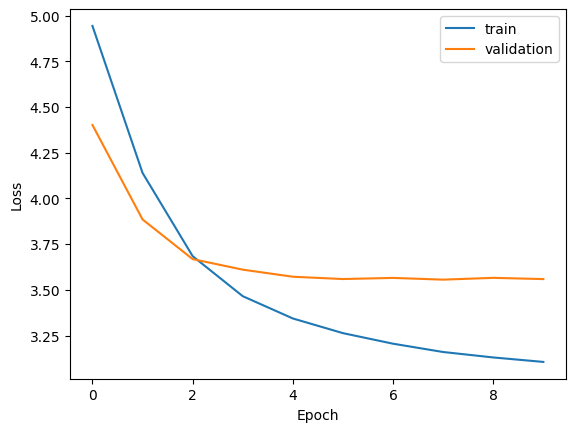

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
def extract_features(fileName, model):
    features = {}
    valid_images = ['.jpg', '.jpeg', '.png']
    try:
            image = Image.open(filename)

    except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
    with Image.open(filename) as image:
            image = image.resize((299, 299))
            image = np.array(image)

            # Convert grayscale to RGB if needed
            if image.ndim == 2:
                image = np.stack((image,) * 3, axis=-1)
            # Convert RGBA to RGB
            if image.shape[-1] == 4:
                image = image[..., :3]

            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)

    feature = model.predict(image)

    return feature

In [ ]:
model = define_model(vocab_size, 34)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 34, 256)   │  1,939,712 │ input_2[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 34, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 34)        │          0 │ input_2[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7577)      │  1,947,289 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.load_weights('model4_3.h5')

In [ ]:
def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None

In [ ]:
def top_k_sample(preds, k=5):
    # Get indices of top k probabilities
    top_k_indices = preds.argsort()[-k:][::-1]
    top_k_probs = preds[top_k_indices]

    # Normalize probabilities to sum to 1
    top_k_probs = top_k_probs / np.sum(top_k_probs)

    # Randomly choose one of the top k indices based on their probabilities
    chosen_index = np.random.choice(top_k_indices, p=top_k_probs)
    return chosen_index

def generate_desc(model, tokenizer, photo, max_length, min_length=5, top_k=5):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        pred = model.predict([photo, sequence], verbose=0)[0]

        # Prevent predicting <end> too early
        end_token_index = tokenizer.word_index.get('end', None)
        if end_token_index is not None and i < min_length:
            pred[end_token_index] = 0

        # Use top_k sampling to choose next word
        pred_index = top_k_sample(pred, k=top_k)

        word = word_for_id(pred_index, tokenizer)
        if word is None:
            break

        in_text += ' ' + word

        if word == 'end':
            break
    return in_text

In [ ]:
def remove_start_end_tokens(sentence):
    tokens = sentence.strip().split()
    if tokens and tokens[0].lower() == 'start':
        tokens = tokens[1:]
    if tokens and tokens[-1].lower() == 'end':
        tokens = tokens[:-1]
    return ' '.join(tokens)

In [ ]:
filename = "/content/2380765956_6313d8cae3.jpg"

test_features = extract_features(filename,Xception_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
tokenizer = load(open("tokenizer4.p","rb"))

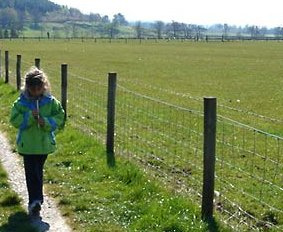

In [ ]:
img = Image.open(filename)
img

In [ ]:
description = generate_desc(model, tokenizer, test_features, 34)

In [ ]:
description = remove_start_end_tokens(description)

In [ ]:
description

'young boy is running in the grass'

In [ ]:
filename = "/content/2677656448_6b7e7702af.jpg"

test_features = extract_features(filename,Xception_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


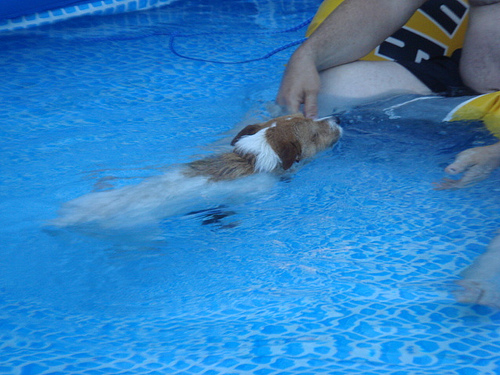

In [ ]:
img = Image.open(filename)
img

In [ ]:
description = generate_desc(model, tokenizer, test_features, 34)

In [ ]:
description = remove_start_end_tokens(description)

In [ ]:
description

'black and white dog is walking through water'

In [ ]:
filename = "/content/69189650_6687da7280.jpg"

test_features = extract_features(filename,Xception_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


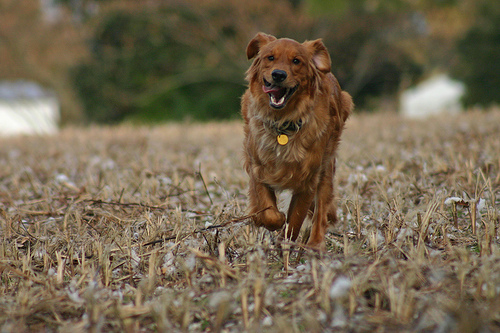

In [ ]:
img = Image.open(filename)
img

In [ ]:
description = generate_desc(model, tokenizer, test_features, 34)

In [ ]:
description = remove_start_end_tokens(description)

In [ ]:
description

'black dog with white dog runs on the grass'